In [1]:
require(ecipex)
require(dplyr)
require(tidyr)
require(ggplot2)


Loading required package: ecipex
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: ggplot2


In [2]:
# methylglutaconyl-CA mass isotopomer distribution

MeGltCoA <- 'C27H42N7O19P3S'

MeGltCoA_data <- 
    ecipex(MeGltCoA, id = T, limit = 1e-6, sortby = 'mass')[[1]] %>%
        mutate(ion_mass = mass + 1.0072) %>%
        mutate(int_mass = round(ion_mass)) %>%
        group_by(int_mass) %>% 
        summarize(abundance = sum(abundance), ion_mass = mean(ion_mass * abundance) / mean(abundance)) %>%
        mutate(molecule = 'native')

In [3]:
# use "Ir" as the fake label for heavy carbon-13
my_iso <- nistiso
my_iso[my_iso$element == 'Ir', 'mass'] <- c(12, 13.003355)
my_iso[my_iso$element == 'Ir', 'abundance'] <- c(0.01, 0.99)  # assume your bicarbonate is 99% labeled
my_iso[my_iso$element == 'Ir', 'nucleons'] <- c(12, 13)

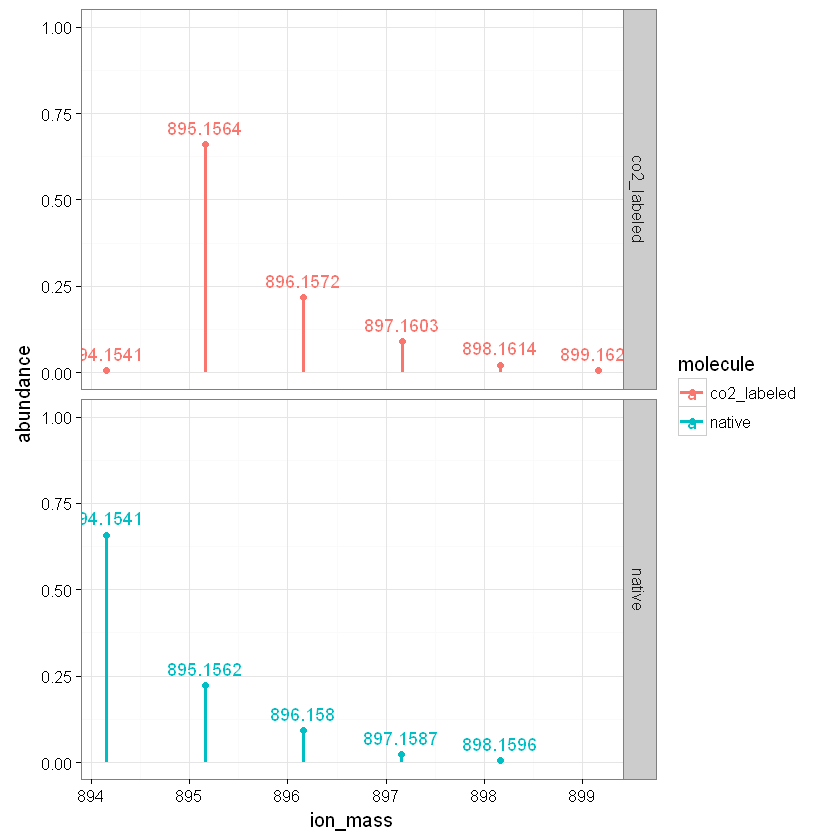

In [4]:
# now find the presumed MID for singly-labeled MeGltCoA 

labeled_MeGltCoA <- 'C26IrH42N7O19P3S'

labeled_MeGltCoA_data <- 
    ecipex(labeled_MeGltCoA, id = T, limit = 1e-6, sortby = 'mass', isoinfo = my_iso)[[1]] %>%
        mutate(ion_mass = mass + 1.0072) %>%
        mutate(int_mass = round(ion_mass)) %>%
        group_by(int_mass) %>% 
        summarize(abundance = sum(abundance), ion_mass = mean(ion_mass * abundance) / mean(abundance)) %>%
        mutate(molecule = 'co2_labeled')


rbind(MeGltCoA_data, labeled_MeGltCoA_data) %>%
    filter(abundance > 0.001) %>%
        ggplot(aes(x = ion_mass, y = abundance, ymin = 0, ymax = abundance, color = molecule)) +
            geom_errorbar(width = 0, size = 1) +
            geom_point() +
            geom_text(aes(label = round(ion_mass, 4)), nudge_y = 0.05) + 
            theme_bw() + 
            facet_grid(molecule~.) +
            ylim(0, 1)

In [5]:
rbind(MeGltCoA_data, labeled_MeGltCoA_data) %>%
    group_by(int_mass) %>%
    select(-ion_mass) %>%
    spread(molecule, abundance) %>%
    mutate(ratio = `co2_labeled` / `native`)

int_mass,co2_labeled,native,ratio
894,6.651913e-03,6.580738e-01,0.01010816
895,6.607129e-01,2.221403e-01,2.97430390
896,2.160748e-01,9.153907e-02,2.36046527
897,8.948962e-02,2.222377e-02,4.02675176
898,2.131689e-02,4.953235e-03,4.30363022
899,4.730495e-03,8.820957e-04,5.36279146
900,8.310343e-04,1.346741e-04,6.17070708
901,1.264340e-04,1.504528e-05,8.40356924
902,1.400783e-05,NA,NA


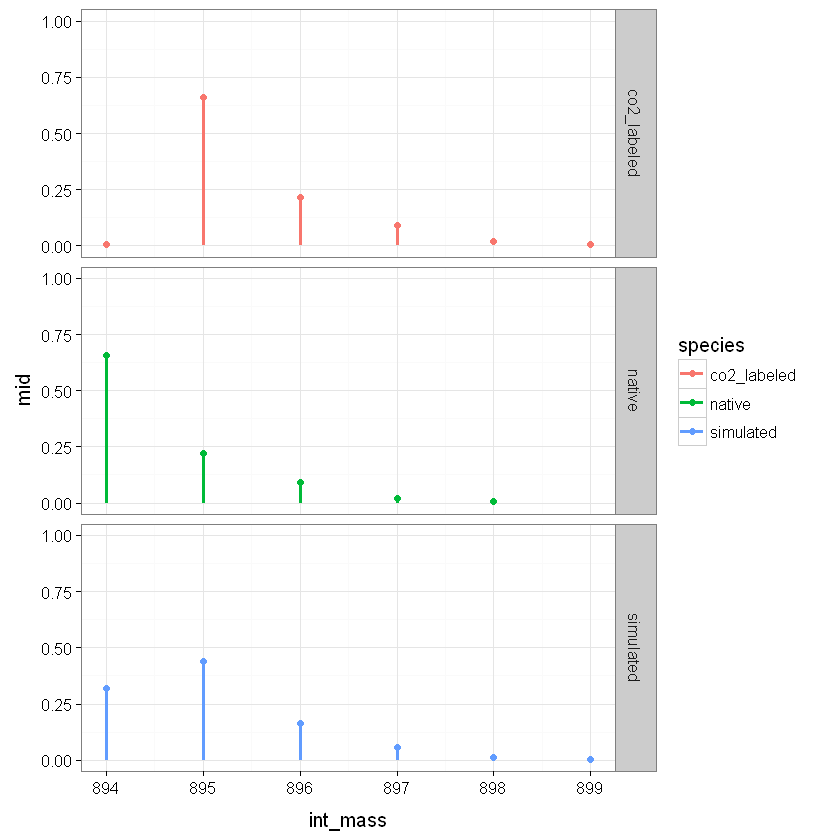

In [6]:
# assume 50% of each pool is around

fraction_labeled <- 0.5

# simulate data
simulated_data <- 
    rbind(MeGltCoA_data, labeled_MeGltCoA_data) %>%
        group_by(int_mass) %>%
        select(-ion_mass) %>%
        spread(molecule, abundance) %>%
        mutate(simulated = (fraction_labeled*co2_labeled + (1-fraction_labeled)*native)*(1 + 0.05*rnorm(length(co2_labeled)))) %>%
        ungroup() %>%
        filter(!is.na(simulated)) %>%
        mutate(simulated = simulated / sum(simulated))


# plot_simulated_data
simulated_data %>% 
 gather(species, mid, co2_labeled:simulated) %>%
 filter(mid > 0.001) %>%
        ggplot(aes(x = int_mass, y = mid, ymin = 0, ymax = mid, color = species)) +
            geom_errorbar(width = 0, size = 1) +
            geom_point() + 
            theme_bw() + 
            facet_grid(species~.) +
            ylim(0, 1)

In [7]:
model <- simulated_data %>% nls(data = ., formula = simulated ~ f*co2_labeled + (1-f)*native, start = list(f = 0.2))

In [8]:
summary(model)


Formula: simulated ~ f * co2_labeled + (1 - f) * native

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
f  0.51325    0.00476   107.8 1.56e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003799 on 7 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 3.01e-07
